# Setup

In [5]:
#Setup
from google.colab import drive
drive.mount('/content/drive')
import os
# TODO: Fill in the Google Drive path where you uploaded the CW_folder_UG
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_folder_UG'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Archie_Short_CW_Folder_UG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['.DS_Store', 'Personal_Dataset', 'Models', 'CW_Dataset', 'Code', 'test_functions.ipynb']


In [6]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import color
from skimage.transform import resize
from skimage.feature import hog
import skimage.feature
from scipy import ndimage, misc
from scipy.signal import gaussian, convolve2d,wiener
import random
import pandas as pd
import cv2
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Load Data

In [7]:
TEST_FOLDER = os.path.join(GOOGLE_DRIVE_PATH,'CW_Dataset/test')
LABEL_FOLDER = os.path.join(GOOGLE_DRIVE_PATH,'CW_Dataset/labels')

testing_data = []

def get_test_labels():
  with open(os.path.join(LABEL_FOLDER,'list_label_test.txt'),'r') as f:
    labels = f.readlines()
  f.close()
  labels = [line[14:] for line in labels]
  labels = [line[:1] for line in labels]
  labels = list(map(int, labels))
  return labels

def get_number(fileName,isTraining):
  if(isTraining):
    trim1 = fileName[5:]
    trim2 = trim1[:4]
  else:
    trim1 = fileName[6:]
    trim2 = trim1[:5]
  cleanId = trim2.lstrip('0')
  return int(cleanId)

test_labels = get_test_labels()

def create_test_data():
  for img in os.listdir(TEST_FOLDER):
    try:
      img_array = cv2.imread(os.path.join(TEST_FOLDER,img),cv2.IMREAD_GRAYSCALE)
      testing_data.append([img_array,test_labels[get_number(img,True)-1]])
    except Exception as e:
      print(e)
  
create_test_data()

invalid literal for int() with base 10: 'data'


In [8]:
print(testing_data)

[[array([[243, 242, 241, ...,   6,   6,   7],
       [242, 241, 240, ...,   6,   6,   7],
       [241, 241, 239, ...,   6,   6,   7],
       ...,
       [231, 230, 230, ..., 220, 222, 223],
       [230, 230, 229, ..., 219, 219, 220],
       [230, 230, 229, ..., 215, 214, 214]], dtype=uint8), 5], [array([[62, 59, 54, ..., 35, 35, 35],
       [76, 71, 64, ..., 36, 35, 35],
       [69, 65, 60, ..., 39, 38, 37],
       ...,
       [48, 44, 37, ..., 38, 39, 40],
       [49, 41, 33, ..., 38, 39, 40],
       [49, 39, 28, ..., 38, 39, 40]], dtype=uint8), 4], [array([[ 23,  17,  20, ...,  55,  52,  51],
       [ 49,  48,  49, ...,  60,  57,  56],
       [ 38,  44,  47, ...,  67,  64,  63],
       ...,
       [ 79,  75,  70, ..., 175, 174, 175],
       [ 81,  79,  79, ..., 165, 159, 156],
       [ 78,  77,  76, ..., 164, 146, 134]], dtype=uint8), 4], [array([[ 55,  65,  79, ..., 136, 130, 124],
       [ 54,  64,  79, ..., 138, 133, 128],
       [ 53,  64,  80, ..., 140, 136, 132],
       ...,
  

# Visualisation function

**References for the code below**

Implementation of HOG https://www.thepythoncode.com/article/hog-feature-extraction-in-python https://ieeexplore.ieee.org/document/5771368 

Implementation of LBP https://fairyonice.github.io/implement-lbp-from%20scratch.html https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_local_binary_pattern.html

Wiener Filter smoothing https://www.researchgate.net/figure/Wiener-Filter-implementation-using-Python_fig3_332574579 

Exposure balancing implementation I followed https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html 

4900
3600


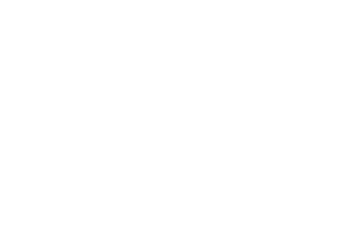

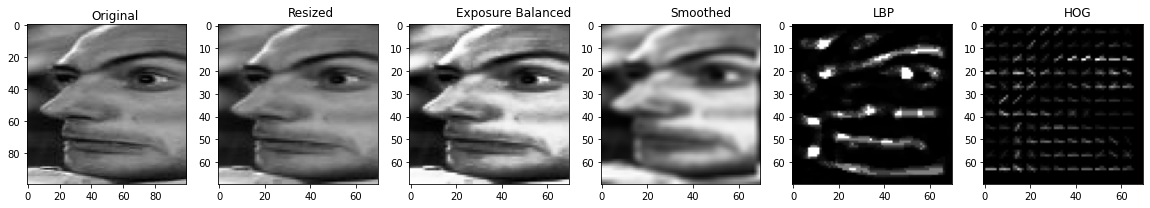

In [9]:
from numpy.fft import fft2, ifft2

#reference https://www.researchgate.net/figure/Wiener-Filter-implementation-using-Python_fig3_332574579  
def gaussian_kernal(kernel_size =3):
  h = gaussian(kernel_size,kernel_size/3).reshape(kernel_size,1) 
  h = np.dot(h,h.transpose())
  h /= np.sum(h) 
  return h 

def wiener_filter(img,kernel,k):
  kernel /= np.sum(kernel)
  dummy = np.copy(img)
  dummy = fft2(dummy)
  kernel = fft2(kernel, s=img.shape)
  kernel = np.conj(kernel) / (np.abs(kernel)**2 + k)
  dummy = dummy * kernel
  dummy = np.abs(ifft2(dummy))
  return dummy 

def convert_space(img):
  for count, pixel in enumerate(img):
    print(pixel)
   # img[count] = (int)(pixel*255.999)
  return img

from skimage.feature import local_binary_pattern


def visualise_pipeline(img):
  #Resize Image
  resized_image = cv2.resize(img, (70, 70)) 

  #reference https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html  
  #Equalise the image exposure
  equalisedImage = cv2.equalizeHist(resized_image)

  #Smooth noise with Wiener
  kernel = gaussian_kernal(4)
  wienerImage = wiener_filter(equalisedImage,kernel,k=5)

  #reference https://fairyonice.github.io/implement-lbp-from%20scratch.html https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_local_binary_pattern.html

  #Get LBP feature vector
  radius = 5
  n_points = 3 * radius
  lbp = local_binary_pattern(wienerImage, n_points, radius,"ror")
  lbpVector = lbp.ravel()

  #reference https://www.thepythoncode.com/article/hog-feature-extraction-in-python https://ieeexplore.ieee.org/document/5771368 

  #Get HOG feature vector
  hogVector,im = hog(equalisedImage, orientations=9, pixels_per_cell=(6,6),cells_per_block=(2, 2), block_norm = "L2",visualize=True,  transform_sqrt=True, feature_vector=True, multichannel=None)
  

  print(len(lbpVector))
  print(len(hogVector))
  plt.axis('off')
  f, axarr = plt.subplots(1,6, figsize=(20, 25))
  
  axarr[0].imshow(img,cmap="gray")
  axarr[0].text(40,-4.0,"Original",fontsize='large')
  axarr[1].imshow(resized_image,cmap="gray")
  axarr[1].text(30,-4.0,"Resized",fontsize='large')

  axarr[2].imshow(equalisedImage,cmap="gray")
  axarr[2].text(20,-4.0,"Exposure Balanced",fontsize='large')

  axarr[3].imshow(wienerImage,cmap="gray")
  axarr[3].text(30,-4.0,"Smoothed",fontsize='large')

  axarr[4].imshow(lbp,cmap="gray")
  axarr[4].text(35,-4.0,"LBP",fontsize='large')

  axarr[5].imshow(im,cmap="gray")
  axarr[5].text(35,-4.0,"HOG",fontsize='large')



visualise_pipeline(testing_data[200][0])
#plt.imshow(training_data[221][0],cmap="gray")
